<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Getting-started" data-toc-modified-id="Getting-started-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Getting started</a></span><ul class="toc-item"><li><span><a href="#Helper-functions" data-toc-modified-id="Helper-functions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Helper functions</a></span></li><li><span><a href="#Inspecting-data" data-toc-modified-id="Inspecting-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Inspecting data</a></span></li></ul></li><li><span><a href="#Train-a-simple-convnet-(using-Pytorch/fastai)" data-toc-modified-id="Train-a-simple-convnet-(using-Pytorch/fastai)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Train a simple convnet (using Pytorch/fastai)</a></span><ul class="toc-item"><li><span><a href="#Simple-convnet" data-toc-modified-id="Simple-convnet-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Simple convnet</a></span></li><li><span><a href="#Construct-a-fastai-learner-object" data-toc-modified-id="Construct-a-fastai-learner-object-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Construct a fastai <code>learner</code> object</a></span></li><li><span><a href="#Understanding-the-number-of-parameters" data-toc-modified-id="Understanding-the-number-of-parameters-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Understanding the number of parameters</a></span></li><li><span><a href="#Finding-an-optimal-learning-rate" data-toc-modified-id="Finding-an-optimal-learning-rate-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Finding an optimal learning rate</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#More-training:-learning-rate-annealing" data-toc-modified-id="More-training:-learning-rate-annealing-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>More training: learning rate annealing</a></span></li><li><span><a href="#Making-predictions" data-toc-modified-id="Making-predictions-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Making predictions</a></span></li></ul></li><li><span><a href="#Learning-rate-annealing" data-toc-modified-id="Learning-rate-annealing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Learning rate annealing</a></span></li><li><span><a href="#A-deeper-convnet" data-toc-modified-id="A-deeper-convnet-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>A deeper convnet</a></span><ul class="toc-item"><li><span><a href="#Use-test-time-augmentation" data-toc-modified-id="Use-test-time-augmentation-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Use test-time augmentation</a></span></li></ul></li><li><span><a href="#Using-a-fastai-resnet-model" data-toc-modified-id="Using-a-fastai-resnet-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Using a <code>fastai</code> resnet model</a></span></li><li><span><a href="#Using-a-pretrained-(frozen)-resnet" data-toc-modified-id="Using-a-pretrained-(frozen)-resnet-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Using a pretrained (frozen) resnet</a></span></li><li><span><a href="#Using-a-pretrained-resnet-with-layered-learning-rates" data-toc-modified-id="Using-a-pretrained-resnet-with-layered-learning-rates-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Using a pretrained resnet with layered learning rates</a></span><ul class="toc-item"><li><span><a href="#Initial-fine-tuning" data-toc-modified-id="Initial-fine-tuning-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Initial fine-tuning</a></span></li><li><span><a href="#Unfreeze-early-layer-groups" data-toc-modified-id="Unfreeze-early-layer-groups-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Unfreeze early layer groups</a></span></li></ul></li></ul></div>

# Getting started

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import torch 

from IPython.display import display

In [2]:
torch.cuda.is_available()

False

## Helper functions

In [3]:
sys.path.append('../src')
from multiclass import *

In [4]:
def load_image(idx, df, ax=None, annotate=True):
    """Helper function to display and annotate image"""
    
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
        
    Z_true, Z_pred = df.iloc[idx]
    name = df.index[idx]
    
    # get image
    image = plt.imread(f'{PATH}/test/{name}.jpg')
    ax.imshow(image)
    ax.axis('off')
    
    # label
    if annotate:
        fontdict = dict(color='white', size=18)
        #ax.text(0.5, 0.9, f'{name}', fontdict=fontdict, transform=ax.transAxes, ha='center', va='bottom')
        ax.text(0.95, 0.125, r'$Z_{\rm true}$' + f' = {Z_true:.3f}', fontdict=fontdict, transform=ax.transAxes, ha='right', va='bottom')
        ax.text(0.95, 0.025, r'$Z_{\rm pred}$' + f' = {Z_pred:.3f}', fontdict=fontdict, transform=ax.transAxes, ha='right', va='bottom')

## Inspecting data

In [6]:
PATH = os.path.abspath('..')
!ls {PATH}

catalogs	     get_images.sh  LICENSE  notebook	src   tmp
environment-cpu.yml  images	    models   README.md	test  train


In [7]:
!ls {PATH}/catalogs

test.csv  test.filenames  train.csv  train.filenames


In [8]:
train_label_csv = f'{PATH}/catalogs/train.csv'
df = pd.read_csv(train_label_csv, index_col=0)

display(df.sample(5, random_state=1234))

# save a subset (20%) for validation
n = len(df)
val_idxs = get_cv_idxs(n, val_pct=0.2)

,oh_p50
objID,
1237657119477334357,8.459984
1237658917995086018,8.826601
1237658493346644079,8.583775
1237657775005630813,8.994787
1237668496849830008,8.984790


Here we're looking at two columns in a `pandas` DataFrame: the SDSS `objID` and also the [O/H] gas-phase metallicity as determined from SDSS spectroscopy.

In [9]:
display(df.describe())

,oh_p50
count,400.000000
mean,8.901004
std,0.199803
min,8.133490
25%,8.824294
50%,8.950793
75%,9.047316
max,9.260791


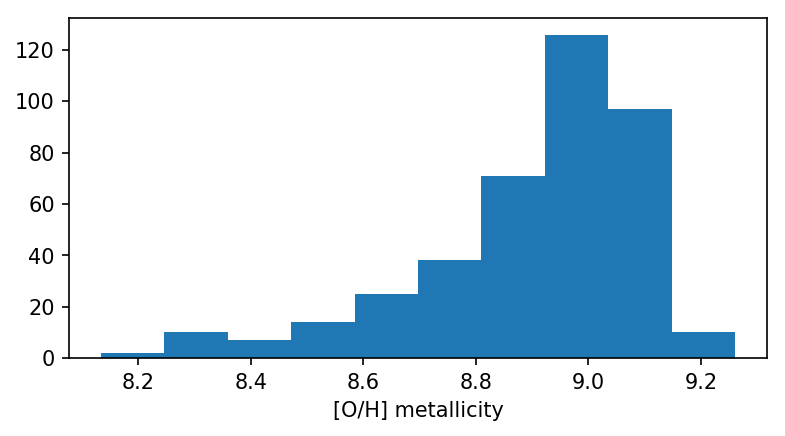

In [15]:
plt.figure(figsize=(6,3), dpi=150)
plt.hist(df.oh_p50)
plt.xlabel('[O/H] metallicity');

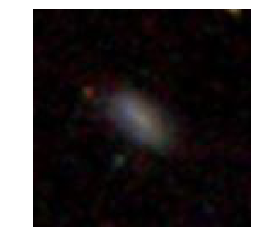

In [16]:
image = plt.imread(f'{PATH}/train/1237657119477334357.jpg')
plt.imshow(image)
plt.axis('off');

# Train a simple convnet (using Pytorch/fastai)

## Simple convnet 
Inspired by a [notebook](https://github.com/richardagalvez/basic-intro-pytorch) by R. Galavez

In [23]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(32*32*32, 1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

## Construct a fastai `learner` object

In [24]:
# image size
sz = 128

# batch size
bs = 4

# architecture
arch = SimpleCNN()

In [25]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
data = ImageClassifierData.from_multiclass_csv(PATH, 'train', train_label_csv, tfms=tfms, bs=bs,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=4)

In [26]:
# construct fastai learner object 
learn = ConvLearner.from_model_data(arch, data)

# IMPORTANT! make sure we're using the RMSE loss function
learn.crit = rmse

In [28]:
display(learn)

print('Number of parameters:')
display([o.numel() for o in learn.model.parameters()])

SimpleCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (fc): Linear(in_features=32768, out_features=1, bias=True)
)

Number of parameters:


[1200, 16, 16, 16, 12800, 32, 32, 32, 32768, 1]

In [22]:
display(learn.summary())

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 16, 128, 128]),
                           ('trainable', True),
                           ('nb_params', 1216)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 16, 128, 128]),
                           ('output_shape', [-1, 16, 128, 128]),
                           ('trainable', True),
                           ('nb_params', 32)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 16, 128, 128]),
                           ('output_shape', [-1, 16, 128, 128]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 16, 128, 128]),
                           ('output_shape', [-1, 16, 64, 64]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 16, 64, 64]

## Understanding the number of parameters
* **(Layer 1)** We find $16 \times 5 \times 5 \times 32 = 1200$, plus $16$ (for bias terms), and then $2\times 16$ for the BatchNorm mean and standard deviation. ✓
* **(Layer 2)** $32 \times (5 \times 5 \times 16 + 1) = 12832$, and then $2 \times 32$ for BatchNorm ✓
* **(Fully connected)** $32 \times 32 \times 32 + 1 = 32769$ ✓

## Finding an optimal learning rate

Why is this important? It can make gradient descent significantly faster or slower (from [Jeremy Jordan](https://www.jeremyjordan.me/nn-learning-rate/)):
![](https://cdn-images-1.medium.com/freeze/max/1000/1*An4tZEyQAYgPAZl396JzWg.png)

An algorithm proposed by [L. Smith (2015)](https://arxiv.org/abs/1506.01186) allows us to find an optimal starting learning rate. We "probe" the network using logarithmically increasing learning rates, in order to see how the loss function responds. If it continues to decrease, then our learning rate is suitable for training.

**This is built into `fastai` and is one of its most useful features!**

 79%|███████▉  | 63/80 [00:07<00:01,  9.44it/s, loss=18]  


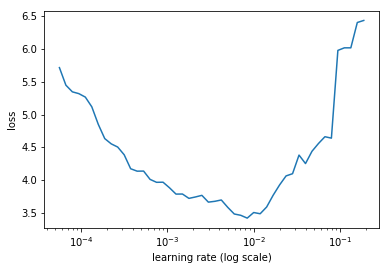

In [16]:
learn.lr_find()
learn.sched.plot()

Recall that we only have 320 training + 80 validation examples, so for a batch size of 4, we expect 80 iterations per epoch. (A batch size of 4 is tiny, but basically unavoidable!)

Anyway, here it appears that at $3 \times 10^{-3}$ the learning rate bottoms out. We'll select about an order of magnitude below this, or $3\times 10^{-4}$, since that tends to work well.

## Training

epoch      trn_loss   val_loss                            
    0      1.169898   0.693488  
    1      0.746717   0.906979                             



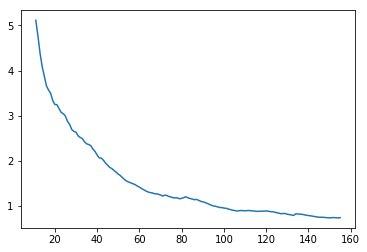

In [20]:
lr = 3e-4

# train model for two epochs
learn.fit(lr, n_cycle=2)

# show loss vs. iteration
learn.sched.plot_loss()

**More training...**

Since the RMSE still appears to be improving, we'll keep training with the same learning rate.

epoch      trn_loss   val_loss                             
    0      0.822554   1.929751  



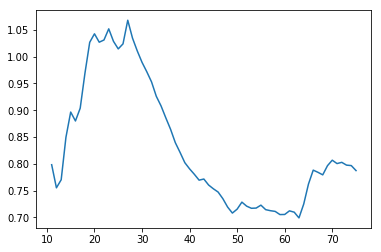

In [21]:
learn.fit(lr, 1)
learn.sched.plot_loss()

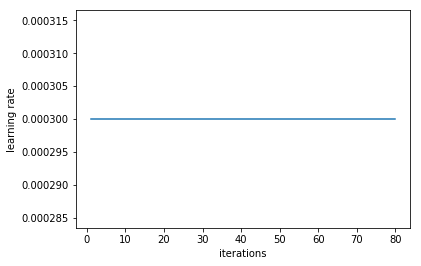

In [22]:
learn.sched.plot_lr()

## More training: learning rate annealing

Why would we do this? Well the learning rate is effectively the step size for traversing the loss function space. I like to think about it as re-scaling the space, as illustrated by [Dinh et al. (2017)](https://arxiv.org/pdf/1703.04933.pdf):

![](https://cdn-images-1.medium.com/max/800/1*OL2g-qtD5OwcgtRNGby2sg.png)

Let's now *anneal* the learning rate by an order of magnitude and fit two more epochs.

epoch      trn_loss   val_loss                             
    0      0.410886   0.488044  
    1      0.318455   0.220977                             



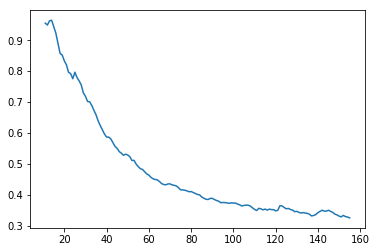

In [23]:
lr = 3e-5
learn.fit(lr, n_cycle=2)
learn.sched.plot_loss()

More annealing and training.

epoch      trn_loss   val_loss                             
    0      0.313508   0.212158  
    1      0.279781   0.20881                              



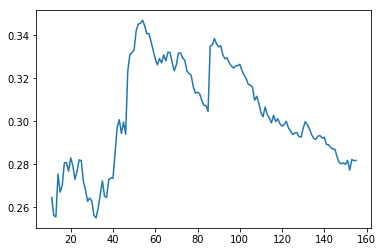

In [24]:
lr = 1e-5
learn.fit(lr, n_cycle=2)
learn.sched.plot_loss()

Here the validation loss is bottoming out at about RMSE $\approx 0.20$ dex.

## Making predictions

In [25]:
# run test (no augmentation)
Z_pred = learn.predict(is_test=True)

In [26]:
# construct answer key
test_names = np.array([os.path.split(fname)[1][:-4] for fname in learn.data.test_ds.fnames], dtype=np.int64)
df_test = pd.read_csv(f'{PATH}/catalogs/test.csv', index_col=0)
Z_true = df_test.loc[test_names].values

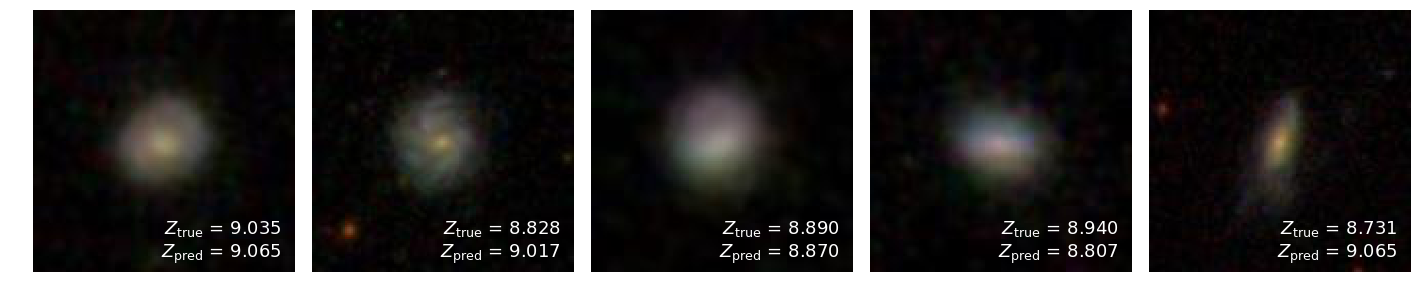

In [27]:
# show results
res = pd.DataFrame({'Z_pred': Z_pred.flatten(), 'Z_true': Z_true.flatten()}, index=test_names)

# random selection of five galaxies
rand = res.sample(frac=1., random_state=1234)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for idx in range(5):
    ax = axes.flat[idx]
    load_image(idx, rand, ax=ax)
    
fig.tight_layout()
fig.subplots_adjust(wspace=0.03, hspace=0.03)

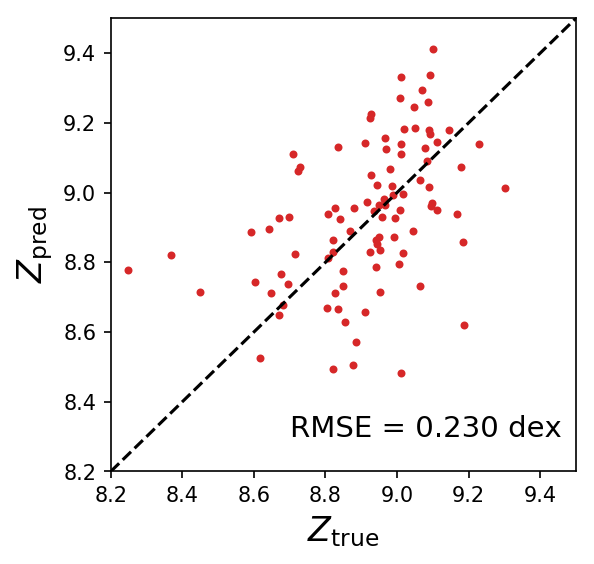

In [28]:
f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
ax.scatter(Z_true.flatten(), Z_pred.flatten(), s=8, c='C3')

ax.set_xlim(8.2, 9.5)
ax.set_ylim(8.2, 9.5)

ax.set_xlabel(r'$Z_{\rm true}$', fontsize=16)
ax.set_ylabel(r'$Z_{\rm pred}$', fontsize=16)

ax.text(8.7, 8.3, f'RMSE = {rmse_np(Z_true, Z_pred):.3f} dex', fontsize=14)

ax.plot(ax.get_xlim(), ax.get_ylim(), ls='--', c='k');

Not bad for a net with only two convolutional layers, and about **80 seconds** on my Dell XPS13...

# Learning rate annealing

In [29]:
sz = 128
bs = 4
arch = SimpleCNN()

tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
data = ImageClassifierData.from_multiclass_csv(PATH, 'train', train_label_csv, tfms=tfms, bs=bs,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=4)

# remember that you need to re-set the loss function criterion EVERY TIME
learn = ConvLearner.from_model_data(arch, data)
learn.crit = rmse

Here we will use a different strategy. We'll now use a flat learning rate for two epochs, cosine annealing for one epoch, and then cosine anneal for two epochs, and then cosine anneal for four epochs (a total of three *cycles* and seven *epochs*).

Note that dropout layers sometimes make the training loss worse than the validation loss. (This tends to be the case when we are not overfitting.)

In [30]:
# two epochs of flat learning rate training
learn.fit(3e-4, 2) 

# and then cosine annealing schedule 
learn.fit(1e-4, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                            
    0      1.591339   0.279937  
    1      0.807255   0.901026                             



epoch      trn_loss   val_loss                             
    0      0.407936   0.234357  
    1      0.539161   0.514648                             
    2      0.379909   0.175841                             
    3      0.392255   0.488444                             
    4      0.366533   0.241755                             
    5      0.297765   0.164306                             
    6      0.245897   0.151068                             



[array([0.15107])]

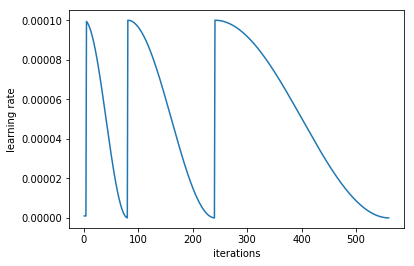

In [31]:
learn.sched.plot_lr()

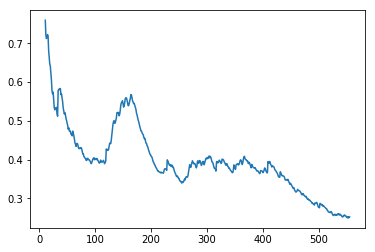

In [32]:
learn.sched.plot_loss()

In [33]:
Z_pred = learn.predict(is_test=True)

In [34]:
print(f'Test RMSE = {rmse_np(Z_true, Z_pred):.3f} dex')

Test RMSE = 0.183 dex


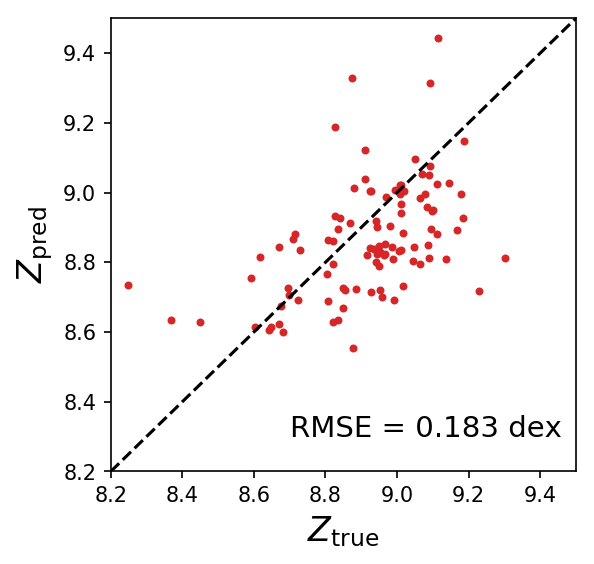

In [35]:
f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
ax.scatter(Z_true.flatten(), Z_pred.flatten(), s=8, c='C3')

ax.set_xlim(8.2, 9.5)
ax.set_ylim(8.2, 9.5)

ax.set_xlabel(r'$Z_{\rm true}$', fontsize=16)
ax.set_ylabel(r'$Z_{\rm pred}$', fontsize=16)

ax.text(8.7, 8.3, f'RMSE = {rmse_np(Z_true, Z_pred):.3f} dex', fontsize=14)

ax.plot(ax.get_xlim(), ax.get_ylim(), ls='--', c='k');

# A deeper convnet
Inspired by the [fastai notebook](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson7-cifar10.ipynb)

In [50]:
class ConvBnNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, layers[0], kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(2))
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(layers[i], layers[i + 1], kernel_size=5, padding=2),
                nn.BatchNorm2d(layers[i + 1]),
                nn.ReLU(),
                nn.MaxPool2d(2))
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], 1)
        
    def forward(self, x):
        x = self.conv1(x)
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return self.out(x).view(-1)

In [51]:
arch = ConvBnNet([32, 64, 128])
sz = 128
bs = 4

tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
data = ImageClassifierData.from_multiclass_csv(PATH, 'train', train_label_csv, tfms=tfms, bs=bs,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=4)

learn = ConvLearner.from_model_data(arch, data)
learn.crit = rmse

In [52]:
display(learn)
display([o.numel() for o in learn.model.parameters()])

ConvBnNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    )
  )
  (out): Linear(in_features=128, out_features=1, bias=True)
)

[4704, 32, 51200, 64, 64, 64, 204800, 128, 128, 128, 128, 1]

In [53]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 32, 64, 64]),
                           ('trainable', True),
                           ('nb_params', 4736)])),
             ('MaxPool2d-2',
              OrderedDict([('input_shape', [-1, 32, 64, 64]),
                           ('output_shape', [-1, 32, 32, 32]),
                           ('nb_params', 0)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 32, 32, 32]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 51264)])),
             ('BatchNorm2d-4',
              OrderedDict([('input_shape', [-1, 64, 32, 32]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 128)])),
             ('ReLU-5',
              Orde

 85%|████████▌ | 68/80 [00:05<00:00, 14.29it/s, loss=144] 


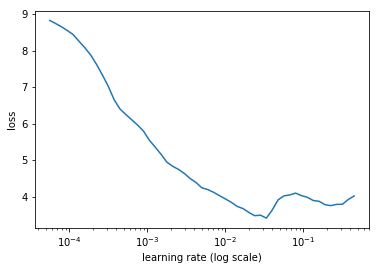

In [54]:
learn.lr_find()
learn.sched.plot()

In [55]:
learn.fit(3e-3, 1)
learn.fit(1e-3, 1)

epoch      trn_loss   val_loss                             
    0      0.893404   0.615433  



epoch      trn_loss   val_loss                             
    0      0.390304   0.224269  



[array([0.22427])]

epoch      trn_loss   val_loss                             
    0      0.24018    0.193732  
    1      0.20996    0.158699                             



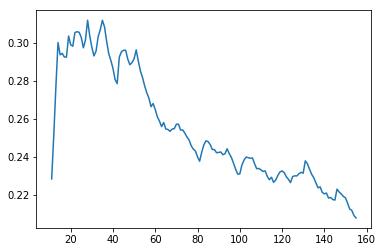

In [56]:
# some cosine annealing
learn.fit(3e-4, 1, cycle_len=2)
learn.sched.plot_loss()

epoch      trn_loss   val_loss                             
    0      0.195239   0.161149  
    1      0.184756   0.163501                             
    2      0.180774   0.154087                             
    3      0.176014   0.15499                              



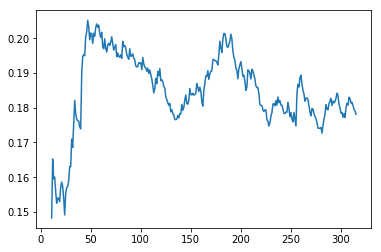

In [57]:
learn.fit(1e-4, 1, cycle_len=4)
learn.sched.plot_loss()

epoch      trn_loss   val_loss                             
    0      0.168905   0.160521  
    1      0.178132   0.167207                             
    2      0.178807   0.154008                             
    3      0.17445    0.158042                             
    4      0.169248   0.153698                             
    5      0.165725   0.15489                              
    6      0.166224   0.155909                             



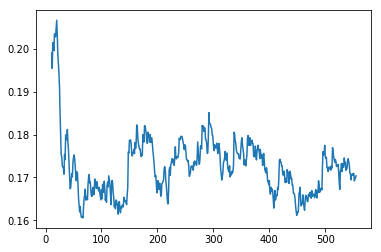

In [58]:
learn.fit(3e-5, 3, cycle_len=1, cycle_mult=2)
learn.sched.plot_loss()

Not bad for my laptop...

In [59]:
Z_pred = learn.predict(is_test=True)
print(f'Test RMSE = {rmse_np(Z_true, Z_pred):.3f} dex')

Test RMSE = 0.246 dex


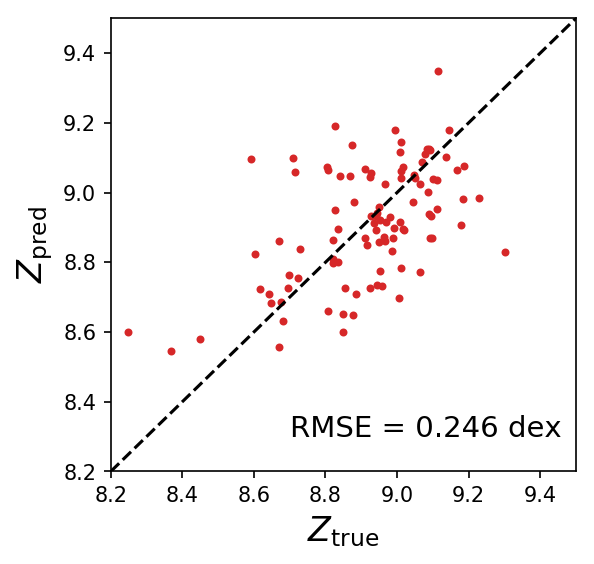

In [60]:
f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
ax.scatter(Z_true.flatten(), Z_pred.flatten(), s=8, c='C3')

ax.set_xlim(8.2, 9.5)
ax.set_ylim(8.2, 9.5)

ax.set_xlabel(r'$Z_{\rm true}$', fontsize=16)
ax.set_ylabel(r'$Z_{\rm pred}$', fontsize=16)

ax.text(8.7, 8.3, f'RMSE = {rmse_np(Z_true, Z_pred):.3f} dex', fontsize=14)

ax.plot(ax.get_xlim(), ax.get_ylim(), ls='--', c='k');

## Use test-time augmentation

In [61]:
Z_pred, _ = learn.TTA(is_test=True)
Z_pred = Z_pred.mean(axis=0)
print(f'Test RMSE = {rmse_np(Z_true, Z_pred):.3f} dex')

Test RMSE = 0.238 dex                        


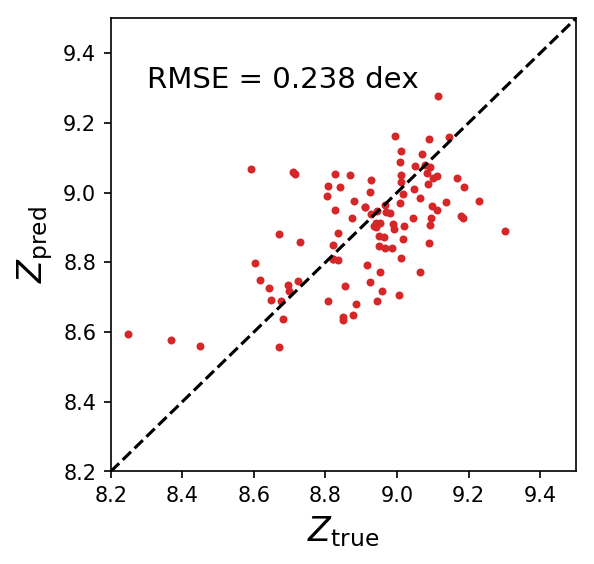

In [62]:
f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
ax.scatter(Z_true.flatten(), Z_pred.flatten(), s=8, c='C3')

ax.set_xlim(8.2, 9.5)
ax.set_ylim(8.2, 9.5)

ax.set_xlabel(r'$Z_{\rm true}$', fontsize=16)
ax.set_ylabel(r'$Z_{\rm pred}$', fontsize=16)

ax.text(8.3, 9.3, f'RMSE = {rmse_np(Z_true, Z_pred):.3f} dex', fontsize=14)

ax.plot(ax.get_xlim(), ax.get_ylim(), ls='--', c='k');

# Using a `fastai` resnet model

In [63]:
arch = resnet18
sz = 128
bs = 8

data = ImageClassifierData.from_multiclass_csv(PATH, 'train', train_label_csv, tfms=tfms, bs=bs,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=4)
learn = ConvLearner.pretrained(arch, data, pretrained=False, precompute=False)
learn.crit = rmse

In [64]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 32, 32]),
      

 88%|████████▊ | 35/40 [00:08<00:01,  4.64it/s, loss=35]  


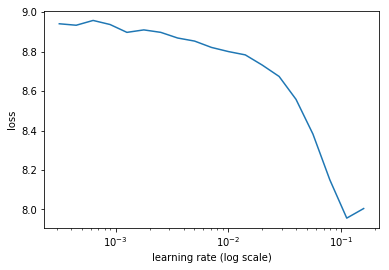

In [65]:
learn.lr_find()
learn.sched.plot()

In [66]:
lr = 1e-2

learn.fit(lr, 4)

epoch      trn_loss   val_loss                            
    0      4.902806   2.664381  
    1      3.157279   0.780563                            
    2      2.741993   0.606204                            
    3      2.320811   0.816963                            



[array([0.81696])]

epoch      trn_loss   val_loss                            
    0      1.872781   0.391281  
    1      1.749059   0.338096                            
    2      1.674605   0.367123                            
    3      1.486575   0.316661                            
    4      1.420333   0.302381                            
    5      1.389636   0.262726                            
    6      1.347      0.273797                            
    7      1.249516   0.250868                            
    8      1.145334   0.246244                            
    9      1.116319   0.265839                            
    10     1.06846    0.217358                            
    11     1.03838    0.234528                            
    12     0.987774   0.220531                             
    13     0.971633   0.237659                             



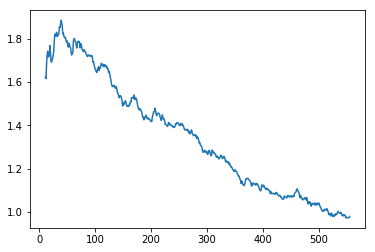

In [67]:
learn.fit(1e-3, 3, cycle_len=2, cycle_mult=2)
learn.sched.plot_loss()

epoch      trn_loss   val_loss                             
    0      0.92244    0.207179  
    1      0.891847   0.219637                             
    2      0.945409   0.210876                             
    3      0.946769   0.208254                             
    4      0.901294   0.19349                              
    5      0.955176   0.198013                             
    6      0.919366   0.197621                             



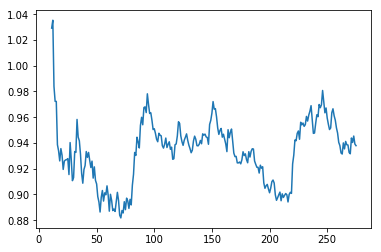

In [68]:
learn.fit(1e-4, 3, cycle_len=1, cycle_mult=2)
learn.sched.plot_loss()

In [69]:
Z_pred, _ = learn.TTA(is_test=True)
Z_pred = Z_pred.mean(axis=0)
print(f'Test RMSE = {rmse_np(Z_true, Z_pred):.3f} dex')

Test RMSE = 0.176 dex                        


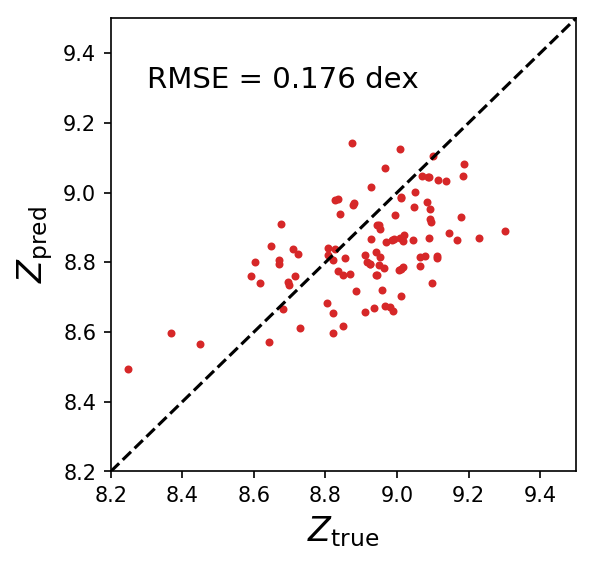

In [70]:
f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
ax.scatter(Z_true.flatten(), Z_pred.flatten(), s=8, c='C3')

ax.set_xlim(8.2, 9.5)
ax.set_ylim(8.2, 9.5)

ax.set_xlabel(r'$Z_{\rm true}$', fontsize=16)
ax.set_ylabel(r'$Z_{\rm pred}$', fontsize=16)

ax.text(8.3, 9.3, f'RMSE = {rmse_np(Z_true, Z_pred):.3f} dex', fontsize=14)

ax.plot(ax.get_xlim(), ax.get_ylim(), ls='--', c='k');

# Using a pretrained (frozen) resnet

In [71]:
arch = resnet18
sz = 128
bs = 8

data = ImageClassifierData.from_multiclass_csv(PATH, 'train', train_label_csv, tfms=tfms, bs=bs,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=4)
learn = ConvLearner.pretrained(arch, data, pretrained=True, precompute=True)
learn.crit = rmse

 72%|███████▎  | 29/40 [00:00<00:00, 65.36it/s, loss=40.2]


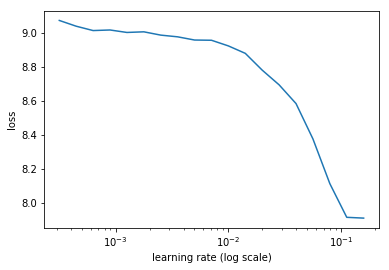

In [72]:
learn.lr_find()
learn.sched.plot()

In [73]:
lr = 1e-2

learn.fit(lr, 20)

epoch      trn_loss   val_loss                            
    0      4.822671   3.075489  
    1      3.433369   1.787462                            
    2      2.660218   1.32501                             
    3      2.307334   1.396972                            
    4      2.098254   1.227552                            
    5      1.898629   1.280112                            
    6      1.655873   1.145794                            
    7      1.575701   1.448246                            
    8      1.534412   0.830763                            
    9      1.29635    0.572521                            
    10     1.144775   0.655115                            
    11     1.086078   1.007758                            
    12     1.038032   0.691792                            
    13     0.969197   0.457621                             
    14     0.899725   0.422688                             
    15     0.829518   0.506004                             
    16     0.765697 

[array([0.38219])]

epoch      trn_loss   val_loss                             
    0      0.546594   0.266274  
    1      0.477805   0.23486                              
    2      0.465213   0.21629                              
    3      0.457382   0.185681                             
    4      0.436959   0.223725                             
    5      0.419121   0.182152                             
    6      0.403523   0.18036                              
    7      0.418905   0.209947                             
    8      0.409856   0.191279                             
    9      0.388602   0.151271                             
    10     0.381166   0.157146                             
    11     0.37547    0.163528                             
    12     0.359767   0.170899                              
    13     0.358089   0.153139                             
    14     0.359981   0.157326                             
    15     0.36284    0.163774                             
    16

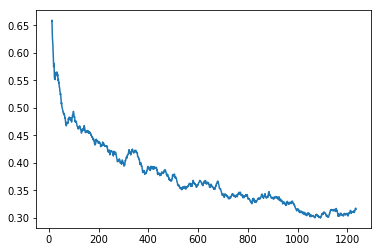

In [74]:
learn.fit(1e-3, 5, cycle_len=1, cycle_mult=2)
learn.sched.plot_loss()

epoch      trn_loss   val_loss                             
    0      0.305055   0.153862  
    1      0.31739    0.161553                             
    2      0.310279   0.155997                             
    3      0.312252   0.148309                             
    4      0.309401   0.153914                             
    5      0.291488   0.159608                              
    6      0.305225   0.163627                              
    7      0.296877   0.148485                             
    8      0.291995   0.145283                             
    9      0.309317   0.146759                             
    10     0.29597    0.143058                             
    11     0.303337   0.148151                             
    12     0.306143   0.14613                              
    13     0.296635   0.157071                              
    14     0.301461   0.157571                             
    15     0.298218   0.15186                              
    

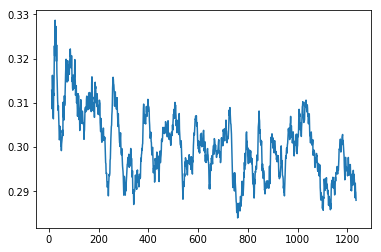

In [75]:
learn.fit(1e-4, 5, cycle_len=1, cycle_mult=2)
learn.sched.plot_loss()

epoch      trn_loss   val_loss                             
    0      0.298943   0.152344  
    1      0.307842   0.151026                             
    2      0.306667   0.148583                             
    3      0.291225   0.158925                             
    4      0.302647   0.156409                             
    5      0.297116   0.150082                             
    6      0.288881   0.155302                             
    7      0.291338   0.146213                             
    8      0.292287   0.150361                             
    9      0.29472    0.153066                             
    10     0.294852   0.149336                             
    11     0.286863   0.141412                             
    12     0.294839   0.151962                             
    13     0.298229   0.151889                             
    14     0.306526   0.150692                             
    15     0.294044   0.147755                             
    16 

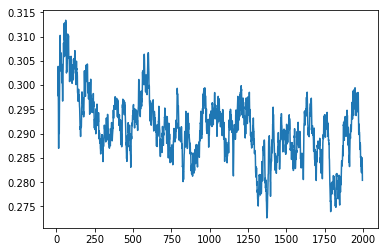

In [76]:
learn.fit(1e-4, 1, cycle_len=50)
learn.sched.plot_loss()

In [77]:
Z_pred, _ = learn.TTA(is_test=True)
Z_pred = Z_pred.mean(axis=0)
print(f'Test RMSE = {rmse_np(Z_true, Z_pred):.3f} dex')

Test RMSE = 0.160 dex                        


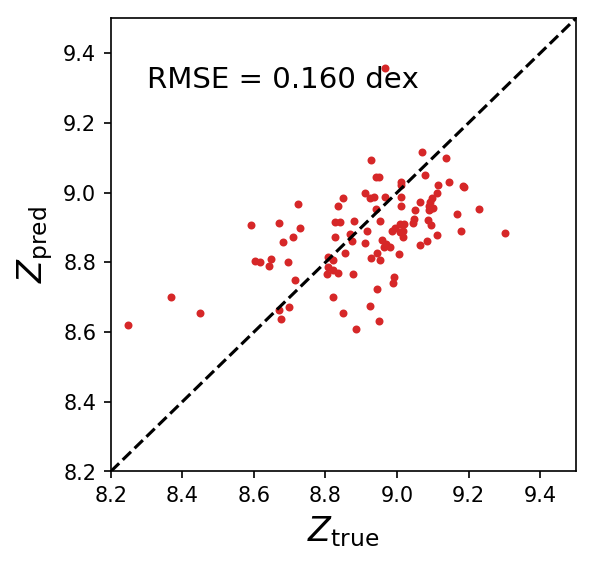

In [78]:
f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
ax.scatter(Z_true.flatten(), Z_pred.flatten(), s=8, c='C3')

ax.set_xlim(8.2, 9.5)
ax.set_ylim(8.2, 9.5)

ax.set_xlabel(r'$Z_{\rm true}$', fontsize=16)
ax.set_ylabel(r'$Z_{\rm pred}$', fontsize=16)

ax.text(8.3, 9.3, f'RMSE = {rmse_np(Z_true, Z_pred):.3f} dex', fontsize=14)

ax.plot(ax.get_xlim(), ax.get_ylim(), ls='--', c='k');

# Using a pretrained resnet with layered learning rates

In [86]:
arch = resnet18
sz = 128
bs = 8

data = ImageClassifierData.from_multiclass_csv(PATH, 'train', train_label_csv, tfms=tfms, bs=bs,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=4)
learn = ConvLearner.pretrained(arch, data, pretrained=True, precompute=True)
learn.crit = rmse

## Initial fine-tuning

In [87]:
learn.fit(1e-2, 20)
learn.fit(1e-3, 20)

epoch      trn_loss   val_loss                            
    0      4.836954   2.217913  
    1      3.246062   1.759463                            
    2      2.643677   1.959464                            
    3      2.432085   1.678623                            
    4      2.104013   1.662307                            
    5      1.870678   1.223744                            
    6      1.797819   0.980002                            
    7      1.55852    0.724184                            
    8      1.370586   0.779459                            
    9      1.277251   1.02716                             
    10     1.264246   0.775409                            
    11     1.114419   0.75935                             
    12     1.029829   0.400366                            
    13     0.931225   0.435599                             
    14     0.865506   0.642408                             
    15     0.82751    0.398514                             
    16     0.805022 

epoch      trn_loss   val_loss                             
    0      0.53451    0.241701  
    1      0.491233   0.187647                             
    2      0.461351   0.178846                             
    3      0.447301   0.21312                               
    4      0.416446   0.234608                             
    5      0.398754   0.204969                              
    6      0.382915   0.214483                              
    7      0.362237   0.179866                              
    8      0.350379   0.153283                             
    9      0.3513     0.152594                             
    10     0.344746   0.176578                             
    11     0.340301   0.172037                             
    12     0.327983   0.161193                             
    13     0.320611   0.176322                             
    14     0.3176     0.166696                             
    15     0.317029   0.166443                              
  

[array([0.16237])]

In [88]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 32, 32]),
      

## Unfreeze early layer groups

In [89]:
learn.unfreeze()

In [90]:
lrs = 3e-4 / np.array([1/9, 1/3, 1])

learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                             
    0      0.330428   0.163238  
    1      0.318755   0.160646                             
    2      0.319778   0.153553                             
    3      0.317765   0.153015                             
    4      0.305147   0.151875                             
    5      0.30514    0.168027                             
    6      0.312246   0.163175                             



[array([0.16318])]

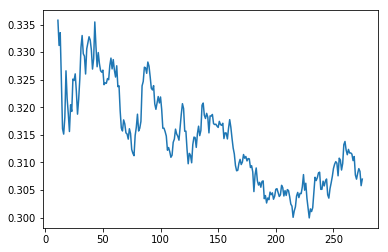

In [91]:
learn.sched.plot_loss()

In [92]:
Z_pred, _ = learn.TTA(is_test=True)
Z_pred = Z_pred.mean(axis=0)
print(f'Test RMSE = {rmse_np(Z_true, Z_pred):.3f} dex')

Test RMSE = 0.153 dex                        


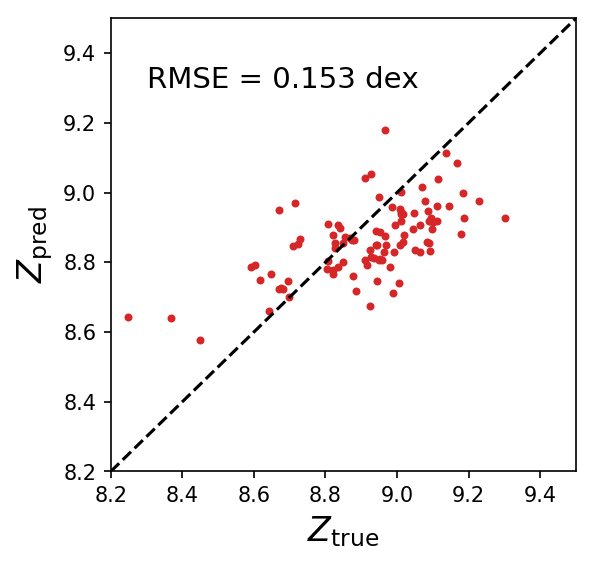

In [93]:
f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
ax.scatter(Z_true.flatten(), Z_pred.flatten(), s=8, c='C3')

ax.set_xlim(8.2, 9.5)
ax.set_ylim(8.2, 9.5)

ax.set_xlabel(r'$Z_{\rm true}$', fontsize=16)
ax.set_ylabel(r'$Z_{\rm pred}$', fontsize=16)

ax.text(8.3, 9.3, f'RMSE = {rmse_np(Z_true, Z_pred):.3f} dex', fontsize=14)

ax.plot(ax.get_xlim(), ax.get_ylim(), ls='--', c='k');